# Imports

In [1]:
!pip install -U ipywidgets


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset

import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset
import torch.utils.data as data_utils

import flwr as fl
from flwr.common import Metrics

# Load Data

In [9]:
data_path = "../sga_data/ex1/adult-subset-for-synthetic.csv"
metadata_table = SingleTableMetadata()
original_data = pd.read_csv(data_path)
metadata_table.detect_from_csv(filepath=data_path)
metadata_table.visualize()

categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "sex", "native-country", "salary-class"]
numeric_cols = ["age", "capital-gain", "hours-per-week"]

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

NUM_CLIENTS = 3
BATCH_SIZE = 32

original_data.head

Training on cpu using PyTorch 2.1.1+cpu and Flower 1.6.0


<bound method NDFrame.head of        age         workclass   education      marital-status  \
0       39         State-gov   Bachelors       Never-married   
1       50  Self-emp-not-inc   Bachelors  Married-civ-spouse   
2       38           Private     HS-grad            Divorced   
3       53           Private        11th  Married-civ-spouse   
4       28           Private   Bachelors  Married-civ-spouse   
...    ...               ...         ...                 ...   
30157   27           Private  Assoc-acdm  Married-civ-spouse   
30158   40           Private     HS-grad  Married-civ-spouse   
30159   58           Private     HS-grad             Widowed   
30160   22           Private     HS-grad       Never-married   
30161   52      Self-emp-inc     HS-grad  Married-civ-spouse   

              occupation   relationship   race     sex  capital-gain  \
0           Adm-clerical  Not-in-family  White    Male          2174   
1        Exec-managerial        Husband  White    Male   

# Preprocess Data and Split

In [4]:
for feature in original_data.columns:
    original_data[feature] = original_data[feature].astype('category').cat.codes


# Split the data: Matr. No: 2210585027
seed = 2210585027
orig_trainig_data, orig_test_data = train_test_split(original_data, test_size=0.2, random_state=seed)

original_data.head

<bound method NDFrame.head of        age  workclass  education  marital-status  occupation  relationship  \
0       22          5          9               4           0             1   
1       33          4          9               2           3             0   
2       21          2         11               0           5             1   
3       36          2          1               2           5             0   
4       11          2          9               2           9             5   
...    ...        ...        ...             ...         ...           ...   
30157   10          2          7               2          12             5   
30158   23          2         11               2           6             0   
30159   41          2         11               6           0             4   
30160    5          2         11               4           0             3   
30161   35          3         11               2           3             5   

       race  sex  capital-gain  c

In [6]:
def load_datasets():
    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    lengths[2] = len(trainset) - 2 * partition_size # modification to get the remaining samples
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(seed))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(seed))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

def set_converter(data):
    tensor = torch.tensor(data.to_numpy(), dtype=torch.float32)
    return data_utils.TensorDataset(tensor[:-1,:-2], tensor[:-1,-1])

training_set = set_converter(orig_trainig_data)
test_set = set_converter(orig_test_data)

df_np = torch.tensor(orig_trainig_data.to_numpy(), dtype=torch.float32)
trainset = data_utils.TensorDataset(df_np[:-1,:-2], df_np[:-1,-1])

df_np = torch.tensor(orig_test_data.to_numpy(), dtype=torch.float32)
testset = data_utils.TensorDataset(df_np[:-1,:-2], df_np[:-1,-1])

trainloaders, valloaders, testloader = load_datasets()

# The Model

In [7]:
import torch.nn as nn

class Deep(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        
        # Define input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Define hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ) for _ in range(num_hidden_layers)
        ])
        
        # Define output layer
        self.output_layer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = nn.ReLU()(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.sigmoid(self.output_layer(x))
        return x

In [8]:
model = Deep(input_size=11, hidden_size=30, num_hidden_layers=3)

### Train / Test Functions

In [10]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for X, y in trainloader: # mod
            X, y = X.to(DEVICE), y.to(DEVICE) # mod
            optimizer.zero_grad()
            outputs = net(X)
            y = torch.unsqueeze(y,1)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += y.size(0)
            correct += (torch.max(outputs.data, 1)[1] == y).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for X, y in testloader: # mod
            X, y = X.to(DEVICE), y.to(DEVICE) # mod
            outputs = net(X)
            y = torch.unsqueeze(y,1)
            loss += criterion(outputs, y).item()
            predicted = outputs.data
            total += y.size(0)
            correct += (predicted.round() == y).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Centralized Learning

In [27]:
NO_EPOCHS = 40
centralized_losses = []
centralized_accuracies = []

trainloader = trainloaders[0]
valloader = valloaders[0]
net = Deep(input_size=11, hidden_size=22, num_hidden_layers=3).to(DEVICE)

for epoch in range(NO_EPOCHS):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    centralized_losses.append(loss)
    centralized_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.013967223613712918, accuracy 0.8171641791044776
Epoch 2: validation loss 0.013340726439187775, accuracy 0.8121890547263682
Epoch 3: validation loss 0.013435905549063612, accuracy 0.8121890547263682
Epoch 4: validation loss 0.013721313309017106, accuracy 0.8159203980099502
Epoch 5: validation loss 0.012913214533928023, accuracy 0.8134328358208955
Epoch 6: validation loss 0.013124167474348154, accuracy 0.8159203980099502
Epoch 7: validation loss 0.013009050332788211, accuracy 0.8308457711442786
Epoch 8: validation loss 0.013018843249895086, accuracy 0.8208955223880597
Epoch 9: validation loss 0.012196554751390249, accuracy 0.818407960199005
Epoch 10: validation loss 0.012694520477335252, accuracy 0.7997512437810945
Epoch 11: validation loss 0.012485775336697327, accuracy 0.8146766169154229
Epoch 12: validation loss 0.012045210440508762, accuracy 0.8233830845771144
Epoch 13: validation loss 0.011596020311117172, accuracy 0.8208955223880597
Epoch 14: validation l

# Federated Learning using Flower Framework

In [28]:
def get_parameters(net) -> list[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: list[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Flower Client

In [30]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

### Using the Virtual Client Engine

In [31]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Deep(input_size=11, hidden_size=22, num_hidden_layers=3).to(DEVICE)

    # Load data (adult data)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### Add Accuracy

In [32]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Federated Training

In [33]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NO_EPOCHS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-12-06 13:52:10,926 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


2023-12-06 13:52:20,689	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-06 13:52:23,912 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 12452141875.0, 'node:127.0.0.1': 1.0, 'memory': 24904283751.0, 'CPU': 12.0, 'node:__internal_head__': 1.0, 'GPU': 1.0}
INFO flwr 2023-12-06 13:52:23,913 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2023-12-06 13:52:23,914 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-12-06 13:52:23,915 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-12-06 13:52:23,927 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO flwr 2023-12-06 13:52:23,928 | server.py:89 | Initializing global parameters
INFO flwr 2023-12-06 13:52:23,929 | server.py:276 | Requesting initial parameters from one

# Final Comparison

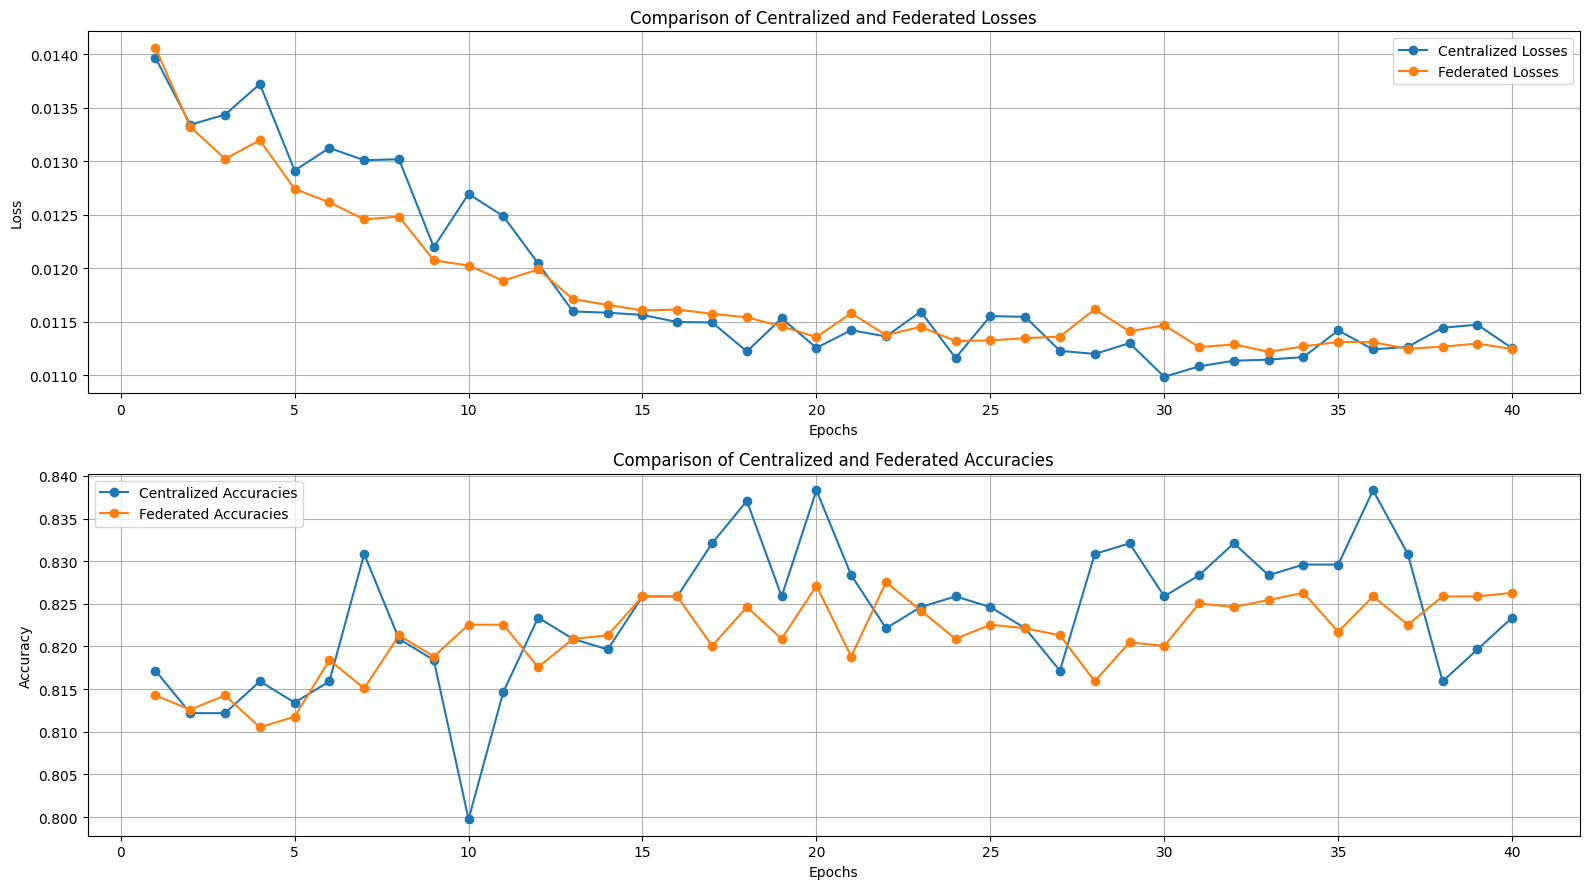

In [41]:
federated_losses = []
for epoch, f_acc in hist.losses_distributed:
    federated_losses.append(f_acc)

federated_accuracies = []
for epoch, f_acc in hist.metrics_distributed["accuracy"]:
    federated_accuracies.append(f_acc)

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["figure.autolayout"] = True
x = np.arange(1, NO_EPOCHS+1)

# Plot losses
plt.subplot(2, 1, 1)
plt.plot(x, centralized_losses, label="Centralized Losses", marker='o')
plt.plot(x, federated_losses, label="Federated Losses", marker='o')
plt.title('Comparison of Centralized and Federated Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
plt.plot(x, centralized_accuracies, label="Centralized Accuracies", marker='o')
plt.plot(x, federated_accuracies, label="Federated Accuracies", marker='o')
plt.title('Comparison of Centralized and Federated Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()